# Sweet list taxi - series numéricas

#### 0.1. Introducción 

Una compañía de taxis desea predecir la cantidad de pedidos de taxis para la próxima hora con el fin de atraer a más conductores durante las horas más ajetreadas del día. Para esta tarea contamos con una base de datos proporcionada por ellos, sobre pedidos de taxis en los aeropuertos. 
Para lograr tal objetivo, entrenaré diferentes modelos de regresión y evaluaré su desempeño con la métrica RMSE. Finalmnete, elegiré el modelo más preciso y lo pondré a prueba con un conjunto de datos apartado justamente para ello. 


#### 0.1.1. Tabla de contendido:

# 1. Preparar datos 

In [1]:
#importar librerias
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


In [2]:
#cargar datos en un dataframe
df_taxis = pd.read_csv('/Users/whitneyrios/PYTHON/My projects py/proyecto 13/Sweet-Lift-Taxi--Series-numericas/dataset/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
#visualizar los datos
df_taxis.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
#viendo la informacion general 
df_taxis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
#verificar valores ausentes 
df_taxis.isna().sum()

num_orders    0
dtype: int64

In [6]:
#verificando descripcion general de los datos
df_taxis.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [7]:
#ordenar el indice en orden cronologico
df_taxis = df_taxis.sort_index()

df_taxis = df_taxis.resample('1h').sum()

In [8]:
#verificar el rango de fechas de la serie temporal
print(df_taxis.index.min())
print(df_taxis.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


Contamos con datos desde el 1 de marzo hasta el 31 de agosto del 2018.

# 2. Análisis de los datos

In [9]:
#examinar la tendencia y estacionalidad de la serie temporal
decomposed = seasonal_decompose(df_taxis['num_orders'])

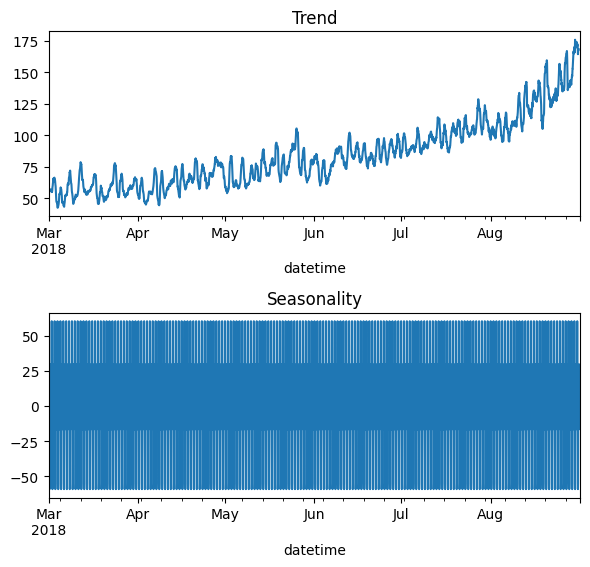

In [10]:
#graficar la tendencia y la estacionalidad de la serie temporal
plt.figure(figsize=(6,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.tight_layout()

Contamos con datos de pedidos desde el mes de marzo hasta el mes de agosto del año 2018. Mediante los gráficos, se aprecia una tendencia ascendente en el número de pedidos y se observa un proceso estacionario en la distribución de los datos.

Text(0.5, 1.0, 'Pedidos del 1er de marzo de 2018')

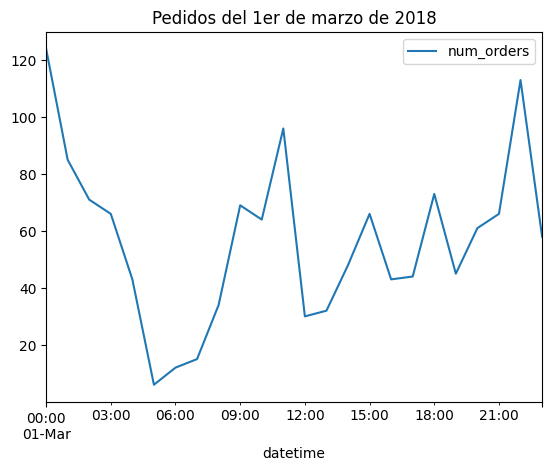

In [11]:
#visualizar la cantidad de pedidos del primer día
df_taxis['2018-03-01':'2018-03-01'].plot()
plt.title('Pedidos del 1er de marzo de 2018')

Text(0.5, 1.0, 'Pedidos del 31 de agosto de 2018')

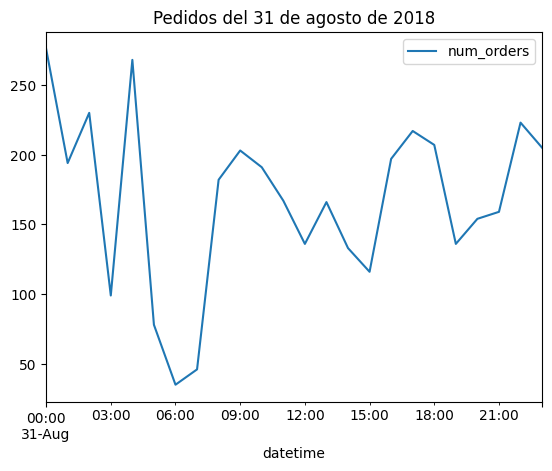

In [12]:
#visualizar la cantidad de pedidos del último día
df_taxis['2018-08-31':'2018-08-31'].plot()
plt.title('Pedidos del 31 de agosto de 2018')

In [13]:
#ver los valores maximos de pedidos
orders = df_taxis.sort_values(by='num_orders', ascending=False).head(20)
orders

,num_orders
datetime,
2018-08-20 02:00:00,462
2018-08-13 02:00:00,437
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342
2018-08-27 04:00:00,295
2018-08-18 00:00:00,281
2018-08-26 00:00:00,281
2018-08-31 00:00:00,276
2018-08-13 01:00:00,273


Mediante un pequeño análisis se puede ver que las horas más concurridas dónde más se realizan más pedidos son:  00:00 a 04:00, 10:00, 16:00, 17:00 y 23:00.
Dicho patrón de horas se puede observar en un gráfico dónde vemos de cerca el primer y último día del conjunto de datos. Por otro lado tamibén se observa que la hora donde menos se realizan pedidos es a las 6:00 am.

# 3. Entrenamiento del modelo

In [14]:
#crear caracteristicas de calendario y desfase
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek 
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag +1):
       data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
       
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() 
    
    return make_features

In [15]:
#función para encontrar el valor rmse
def rmse(y_pred, y):
    mse = mean_squared_error(y_pred, y)
    return mse ** 0.5

In [16]:
#crear caracteristicas
make_features(df_taxis, 6, 10)

<function __main__.make_features(data, max_lag, rolling_mean_size)>

In [25]:
#escalar las características
scaler = StandardScaler()
scaler.fit(df_taxis)

data_scaled = pd.DataFrame(scaler.transform(df_taxis), columns=df_taxis.columns)

data_scaled.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
0,0.879127,0.0,-1.462505,-1.675692,-0.00273,-1.661325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.012822,0.0,-1.462505,-1.675692,-0.00273,-1.516862,0.880350,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.298160,0.0,-1.462505,-1.675692,-0.00273,-1.372399,0.013438,0.881897,NaN,NaN,NaN,NaN,NaN
3,-0.409225,0.0,-1.462505,-1.675692,-0.00273,-1.227936,-0.297761,0.014149,0.882449,NaN,NaN,NaN,NaN
4,-0.920123,0.0,-1.462505,-1.675692,-0.00273,-1.083473,-0.408904,-0.297350,0.014529,0.882941,NaN,NaN,NaN


In [15]:
#segmentar los conjuntos de entrenamiento, validacion y prueba
train, valid = train_test_split(data_scaled, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid, shuffle=False, test_size=0.2)

#eliminar los valores ausentes por el desfase
train = train.dropna()
valid = valid.dropna()

#definir las caracteristicas y el objetivo
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

# 3.1.1. Regresión lineal

In [16]:
#modelo de regresión lineal 
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

pred_lr_valid = model_lr.predict(features_valid)

rmse_lr = rmse(pred_lr_valid, target_valid)

print('Valor RMSE en regresión lineal en conjunto de validación:', rmse_lr)

Valor RMSE en regresión lineal en conjunto de validación: 0.9760617272385635


# 3.1.2. Bosque aleatorio (regresión)

In [17]:
#bosque aleatorio (regresion)
#model_rfr = RandomForestRegressor(random_state=12345)

#params = {
    #'n_estimators' : [5, 8, 10],
    #'max_depth' : [5, 6, 8],
    #'min_samples_split' : [2, 3],
    #'max_features' : [2, 4, 6]
#} 
 
#buscar hiperparametros
#grid = GridSearchCV(estimator=model_rfr, param_grid=params, cv=5)

#grid.fit(features_train, target_train)

In [18]:
#mostrar los mejores hiperparámetros del modelo
#grid.best_params_

In [19]:
#entrenar el modelo con los hiperparametro del grid
model_rfr = RandomForestRegressor(random_state=12345,
                                  n_estimators=10,
                                  max_depth=8,
                                  min_samples_split=2,
                                  max_features=6 
)
                                  
model_rfr.fit(features_train, target_train)

pred_rfr_valid = model_rfr.predict(features_valid)

rmse_rfr = rmse(pred_rfr_valid, target_valid)
                                  
print('Valor RMSE para bosque aleatorio en conjunto de validación:', rmse_rfr)                                 

Valor RMSE para bosque aleatorio en conjunto de validación: 0.9242993694880368


# 3.1.3. Modelo Catboost

In [20]:
#construir un modelo catboost
model_cb = CatBoostRegressor(random_seed=42, loss_function='RMSE', iterations=100, learning_rate=0.8, verbose=10)

model_cb.fit(features_train, target_train)

pred_cb_valid = model_cb.predict(features_valid)

rmse_cb = rmse(pred_cb_valid, target_valid)
print()
print('Valor RMSE en modelo Catboost en conjunto de validación:', rmse_cb)

0:	learn: 0.6001805	total: 62ms	remaining: 6.14s
10:	learn: 0.4462264	total: 136ms	remaining: 1.1s
20:	learn: 0.3929552	total: 251ms	remaining: 942ms
30:	learn: 0.3638073	total: 290ms	remaining: 646ms
40:	learn: 0.3313704	total: 316ms	remaining: 455ms
50:	learn: 0.3045963	total: 336ms	remaining: 323ms
60:	learn: 0.2861359	total: 497ms	remaining: 318ms
70:	learn: 0.2697738	total: 542ms	remaining: 221ms
80:	learn: 0.2554041	total: 562ms	remaining: 132ms
90:	learn: 0.2428798	total: 580ms	remaining: 57.4ms
99:	learn: 0.2286473	total: 598ms	remaining: 0us

Valor RMSE en modelo Catboost en conjunto de validación: 0.9165562726200792


# 3.1.4 Modelo lightGBM

In [21]:
#construir un modelo lighGBM
#model_lgb = LGBMRegressor(random_state=12345, )


#params = {
    #'learning_rate' : [0.1, 0.5, 0.8],
    #'n_estimators' : [40, 60, 80, 100],
    #'max_depth' : [3, 6, 8, 10],
#} 
 
#buscar hiperparametros
#grid = GridSearchCV(estimator=model_lgb, param_grid=params, cv=8)

#grid.fit(features_train, target_train)

In [22]:
#mostrar los mejores hiperparámetros del modelo
#grid.best_params_

In [23]:
#entrenar el modelo con los hiperparametros
model_lgb = LGBMRegressor(random_state=54321,
                          learning_rate=0.1,
                          n_estimators=80, 
                          max_depth=6
)
                
model_lgb.fit(features_train, target_train)

pred_lgb_valid = model_lgb.predict(features_valid)

rmse_lgb = rmse(pred_lgb_valid, target_valid)

print('Valor RMSE para modelo lightGBM en conjunto de validación:', rmse_lgb)

Valor RMSE para modelo lightGBM en conjunto de validación: 0.8490716380834


# 4. Elección del modelo

El modelo que proporcionó el menor valor rmse en el conjunto de validación fue el lightGBM. Por lo tanto, lo pomdré a prueba con el conjunto de prueba.

In [24]:
#calcular valor rmse en conjunto de prueba
pred_lgb_test = model_lgb.predict(features_test)

rmse_lgb_test = rmse(pred_lgb_test, target_test)

print('Valor RMSE para lightGBM en conjunto de prueba:', rmse_lgb_test)

Valor RMSE para lightGBM en conjunto de prueba: 1.4601344493673765


# 5. Conclusiones generales 

Para desarrollar este proyecto preparé el dataset disponible, asegurándome de que los tipos de datos fueran los correspondientes y que no hubieran valores ausentes ni duplicados. 

Una vez con los datos preparados pasé al análisis de los mismos y pude notar una tendencia ascendente en la cantidad de pedidos de taxis a medida que aumentan los meses y nos acercamos al mes de agosto. Por otra parte, también se observó un proceso estacionario en la distribución de los datos y al ver más de cerca mediante un gráfico el primer y el último día registrados en el dataset, correspondientes al 1ero de marzo y el 31 de agosto del 2018, se puede ver que esta distribución estacionaria corresponde a las horas en las que se registra el volumen de los pedidos, teniendo así un patrón de horario donde la hora en la que menos clientes hay, son las 06:00, mientras que las horas más concurridas son: 00:00 a 04:00, 10:00, 16:00, 17:00 y 23:00.

A continuación pasé al entrenamiento de 4  modelos de regresión con la búsqueda de los mejores hiperparámetros mediante la implementación de un GridSearch. Por otra parte, procedí a escalar mis características y posteriormente segmentar tres conjuntos: entrenamiento, validación y prueba. Todos los modelos fueron evaluados con la métrica RMSE. 

Finalmente elegí el modelo lightGBM ya que presentó el valor más bajo en cuanto a la métrica de evaluación (0.84) y lo puse a prueba con el segmento reservado para prueba, obteniendo un valor RMSE bastante bajo de 1.46. 

# 6. Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  	Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48